### Notebook to perform the unsupervised deep image prior generation of simulated nanoparticles reconstruction from simulated degraded acquisition conditions

*The data set consists of 2D images from simulated nanoparticles. The nanoparticles were already forward projected using tomosipo's Radon transform (0°:1°:180°), and reconstructed with limited number of projections and three scenarios using SIRT algorithm to mimic scenario from possible experimental acquisitions of nanoparticles.*
- -60°:2°:+60°
- -60°:10°:+60°
- -30°:2°:+30°

#### The DIP formulation adapted to tomography consists of solving the following problem :

$$ \hat{\theta} = \underset{\theta}{\arg\min} \left\| P F_{\theta}(z) - y \right\|_2^2 $$

Where :
- $ F_{\theta} $ is the network and weights to optimized
- $ P $ is the forward operator (Radon transform)
- $ z $ is an input noise
- $ y $ are the acquired projections

In [ ]:
import sys
sys.path.insert(0, '../../Src')
from model import *
from radon import *
from dip import *
from utils import *

import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import torch
from pathlib import Path

plt.gray()

dtype = torch.cuda.FloatTensor
DEVICE = 'cuda'

<Figure size 640x480 with 0 Axes>

#### Load the simulated nanoparticles image and corresponding sinogram to reconstruct with deep image prior

In [25]:
data_index = 565

IMG_SIZE = 512
radon_full_op = Radon2D(angle=np.deg2rad(np.arange(0.,180.,1.)), size=IMG_SIZE)

reference_reco = imread('../../Data/Simulated/simu_full.tif')[data_index,:,:]
reference_reco = torch.from_numpy(reference_reco).type(dtype)
reference_sino = normalize(radon_full_op.forward(reference_reco))

# 1, 2 or 3 corresponding to acquisition range -60:2:+60, -60:10:+60 and -30:2:+30 respectively
ACQUISITION_CASE = 3
SELECT = {
    1: [reference_sino[30:150:2], np.arange(30.,150.,2.)],
    2: [reference_sino[30:150:10], np.arange(30.,150.,10.)],
    3: [reference_sino[60:120:2], np.arange(60.,120.,2.)],
}

degraded_sino = SELECT[ACQUISITION_CASE][0]
THETA = SELECT[ACQUISITION_CASE][1]

Text(0.5, 1.0, 'Degraded sinogram (missing projections)')

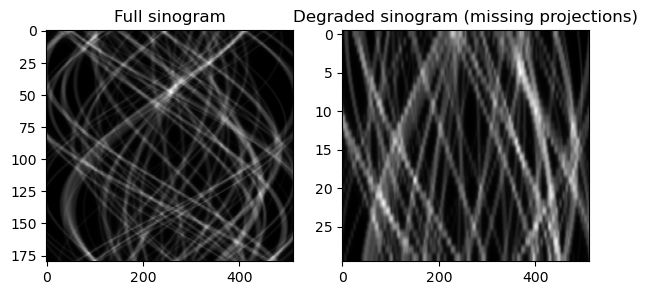

In [26]:
fig, ((ax0, ax1)) = plt.subplots(1, 2, figsize = (7,3))

ax0.imshow((simplify(reference_sino)), aspect='auto')
ax0.set_title('Full sinogram')
ax1.imshow(simplify(degraded_sino), aspect='auto')
ax1.set_title('Degraded sinogram (missing projections)')

#### Networks and training parameters

- INPUT_DEPTH : Shape of the input noise
- STD_INP_NOISE : std of the input noise
- NOISE_REG : regularization value on the input noise after each iteration

In [27]:
NUM_ITER = 2000
LR = 0.01
INPUT_DEPTH = 32
STD_INP_NOISE = 1./10. 
NOISE_REG = 1./30.

In [28]:
n_scale = 4
ud_filters=[16,32,64,128]
skip_filters=[4,8,16,32]
network = model_unet(input_shape=INPUT_DEPTH,
                  output_shape=1,
                  down_filters=ud_filters,
                  up_filters=ud_filters,
                  skip_filters=skip_filters,
                  down_kernels=[3]*n_scale,
                  up_kernels=[3]*n_scale,
                  skip_kernels=[1]*n_scale,
                  up_mode='bilinear',
                  down_mode='stride',
                  pad_mode='zeros',
).to('cuda').type(dtype)

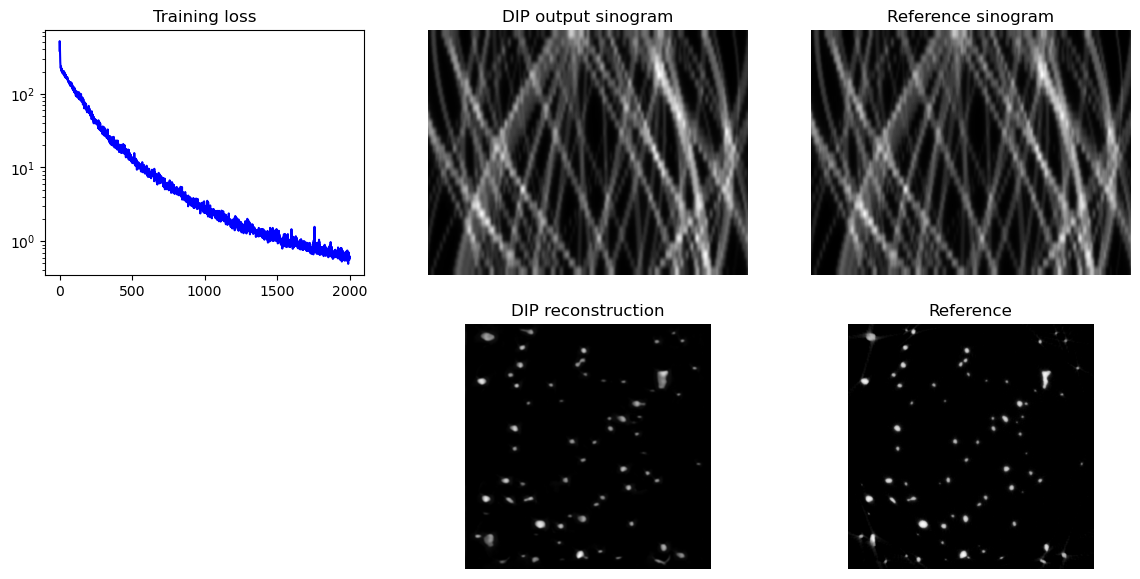

  0%|          | 0/2000 [00:00<?, ?it/s]/nobackup/sb272614/Environments/env_tomo/lib/python3.12/site-packages/torch/nn/modules/loss.py:538: UserWarning: Using a target size (torch.Size([30, 512])) that is different to the input size (torch.Size([1, 1, 30, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 2000/2000 [03:38<00:00,  9.16it/s]


In [29]:
output = dip_reconstruction(NUM_ITER, LR, IMG_SIZE, STD_INP_NOISE, NOISE_REG,
                            np.flip(THETA), INPUT_DEPTH,
                            degraded_sino, reference_reco, network, 
                            tv_weight=0.0, tv_order=1)

best_loss   = output['best_loss']
best_output = normalize(output['best_output'])
best_i      = output['best_i']
loss_values = output['loss_values']
net_trained = output['net']
best_input  = output['best_input']

#### Save the generated restored image

In [30]:
OUT_PATH = Path("../../Temp_out")
if not OUT_PATH.is_dir():
    OUT_PATH.mkdir()

imsave(f'{OUT_PATH}/out_simu_dip_{ACQUISITION_CASE}.tif', simplify(best_output))